# Co-Optimization of Home Appliances

### Import Packages

In [336]:
## Import Packages
from __future__ import division
from cvxpy import *
import numpy as np
import pandas as pd
import xpress
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import interp
from scipy import signal
import control
%matplotlib inline
import gurobipy
import mosek
#installed_solvers()

### Water Heater Optimization

Objective function and constraints for water heater, based on "Appliance Commitment for Household Load Scheduling" by Du and Lu.

In [337]:
# Generate data for control problem.
np.random.seed(1)

# Phyiscal parameters
R = 1.52 #thermal resistance [˚C/kW]
C = 863.4 #thermal capacitance [kWh/˚C]
Q = 4 #heater capacity [kW]
price = np.array(pd.read_csv("prices/prices_tou.csv").price_winter_kwh) #TOU pricing [$/kWh]
M = 50 #heater mass [gal]

# Optimization parameters
dt = 0.25 #time step [h]
n = int(24/dt) #number of time steps
T_0 = 60 #initial heater temp [˚C]
T_min = 55 #min heater temp [˚C]
T_max = 65 #max heater temp [˚C]
T_input = 25 #input heater temp [˚C]

# Water demand : https://learn.compactappliance.com/tankless-water-heater-sizing/
d = np.zeros(n) #heater water demand [gal]
shower_gpm = 1.6 #shower demand [gpm]
washer_gpm = 2.0 #washing machine demand [gpm]
d[37] = shower_gpm * dt * 60 #shower at 9 am
d[73] = washer_gpm * dt * 60/3 #washing machine from 6-6:45 pm
d[74] = washer_gpm * dt * 60/3 
d[75] = washer_gpm * dt * 60/3

# State space representation
beta = 10000 #ratio of increase for B
A = np.e**(-dt/(R*C))
B = beta*Q*R*(1-np.e**(-dt/(R*C)))

# Variables
T = Variable(n+1) #temperature
u = Variable(n, boolean = True) #on/off heater

# Cost function
alpha = 1 #ratio of penalty:cost
cost = sum(multiply(price*Q, u*dt))
for i in range(n+1):
    cost += alpha*0.5*(maximum(0, -T[i]+T_min)**2) #add in penalty function
# Constraints
constr = [T[0] == T_0]
for i in range(n):
    constr += [T[i+1] == A*(((M-d[i])*T[i])/M + (d[i]/M)*T_input) + B*u[i]]
    constr += [T[i+1] <= T_max]

### HVAC Optimization

Objective function and constraints for HVAC, based on "".

In [338]:
# Physical parameters
R=8.02  #[C/kW]
n_ac= 0.35 #[1/h]
A_floor = 100 # [m^2]
height = 3  #[m]
V_house=  A_floor*height #[m^3]
rho_air= 1.2 #[kg/m_3]
C_1 =  8.12   # [kWh/C]
C_2 = 1214.4/rho_air   #[J/(kg*C)]
P_heat=60*A_floor/1000 #[kW]
p=0.995
A_window=4

# # All irradiance in [W/m2]
# Location is Berkeley, CA --> (Lat, Lon) = (37.88, -122.25) 
df_raw = pd.read_csv('HVAC/62695_37.88_-122.25_2019_import.csv')
df_1 = df_raw
# making boolean series for a team name 
df_2 = df_1[df_1['Month'] == 3][df_1['Day'] == 15]
df_15=df_2[(df_2['Minute']==0) | (df_2['Minute']==15) | (df_2['Minute']==30) |(df_2['Minute']==45)]
def deg_to_rad(radians):
    return(radians * np.pi/180)

# Calculate irradiation on module
# Ref: https://www.pveducation.org/pvcdrom/properties-of-sunlight/solar-radiation-on-a-tilted-surface
GHI=df_15['GHI']
phi = 37.8715 # latitude of Berkeley
delta = 23.45 * np.sin(deg_to_rad(360/365 * (284 + 74))) # declination angle, March 15 is 74th day of year
alpha = 90 - phi + delta
beta = 90
S_window = np.array(GHI * (np.sin(deg_to_rad(alpha + beta)) / np.sin(deg_to_rad(alpha)))/1000) #[kW/m_2]

T_out=np.array(df_15['Temperature'])
dt=15/60 #[hr]
n=int(24/dt)  # time steps

dummy = n_ac*V_house*rho_air*C_2/3600000/C_1
A_d = np.exp((-1/C_1/R - dummy)*dt)
B_d = np.array([1/R+dummy*C_1, 1, A_window*(1-p)])*1/C_1*(1/(-1/(R*C_1)-dummy))*(np.exp((-1/(R*C_1)-dummy)*dt)-1)

T_min=20
T_max=24

# Define variables 
n=96
z=Variable(n, boolean=True)  #z_heating
T_in = Variable(n+1)
T_in_0 = 21  #[C]

# optimization starts
for i in range(n):
    constr += [ T_in[i+1] == A_d * T_in[i] + 
               np.matmul(B_d ,(np.array([T_out[i], P_heat*z[i], S_window[i]]).T))]
    constr += [T_in[i+1]>=T_min, T_in[i+1]<=T_max] 
constr += [T_in[0] == T_in_0]    
cost += sum(multiply(price*P_heat, z*dt))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## Solar

In [339]:
# ASSUMED PARAMETERS
eff_panels = np.mean([0.15, 0.22]) # Panel efficiency
n_panels = 8
a_inches_panel = (65 * 39) # inches # https://news.energysage.com/average-solar-panel-size-weight/
a_m2_panel = a_inches_panel / (39.37 ** 2) # area in m2
a_m2_panels = n_panels * a_m2_panel
print('Area of panels on roof (m^2): ', np.round(a_m2_panels, 2))

Area of panels on roof (m^2):  13.08


In [340]:
# All irradiance in [W/m2]
# Location is Berkeley, CA --> (Lat, Lon) = (37.88, -122.25) 
df_raw = pd.read_csv('62695_37.88_-122.25_2019_import.csv')

In [341]:
df_1 = df_raw
# making boolean series for a team name 
df_2 = df_1[df_1['Month'] == 3][df_1['Day'] == 15]
df_2.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,Year,Month,Day,Hour,Minute,DHI,DNI,GHI,Solar Zenith Angle,Surface Albedo,Wind Speed,Temperature,Unnamed: 12
21024,2019,3,15,0,0,0,0,0,144.09,0.12,0.5,9.8,NaN
21025,2019,3,15,0,5,0,0,0,144.20,0.12,0.5,9.7,NaN
21026,2019,3,15,0,10,0,0,0,144.28,0.12,0.5,9.7,NaN
21027,2019,3,15,0,15,0,0,0,144.32,0.12,0.5,9.6,NaN
21028,2019,3,15,0,20,0,0,0,144.32,0.12,0.5,9.6,NaN


In [342]:
df_3 = df_2
df_3['Hour_of_day'] = df_3['Hour'] + (df_3['Minute'] / 60)
df_3.head()

,Year,Month,Day,Hour,Minute,DHI,DNI,GHI,Solar Zenith Angle,Surface Albedo,Wind Speed,Temperature,Unnamed: 12,Hour_of_day
21024,2019,3,15,0,0,0,0,0,144.09,0.12,0.5,9.8,NaN,0.000000
21025,2019,3,15,0,5,0,0,0,144.20,0.12,0.5,9.7,NaN,0.083333
21026,2019,3,15,0,10,0,0,0,144.28,0.12,0.5,9.7,NaN,0.166667
21027,2019,3,15,0,15,0,0,0,144.32,0.12,0.5,9.6,NaN,0.250000
21028,2019,3,15,0,20,0,0,0,144.32,0.12,0.5,9.6,NaN,0.333333


In [343]:
df_3[df_3['DHI'] > 0].head()

,Year,Month,Day,Hour,Minute,DHI,DNI,GHI,Solar Zenith Angle,Surface Albedo,Wind Speed,Temperature,Unnamed: 12,Hour_of_day
21102,2019,3,15,6,30,12,143,15,88.57,0.12,1.4,7.1,NaN,6.500000
21103,2019,3,15,6,35,16,206,24,87.66,0.12,1.4,7.2,NaN,6.583333
21104,2019,3,15,6,40,20,264,35,86.73,0.12,1.4,7.3,NaN,6.666667
21105,2019,3,15,6,45,24,317,47,85.78,0.12,1.4,7.5,NaN,6.750000
21106,2019,3,15,6,50,28,365,61,84.83,0.12,1.4,7.6,NaN,6.833333


In [344]:
def deg_to_rad(radians):
    return(radians * np.pi/180)

In [345]:
# Calculate irradiation on module
# Ref: https://www.pveducation.org/pvcdrom/properties-of-sunlight/solar-radiation-on-a-tilted-surface
phi = 37.8715 # latitude of Berkeley
delta = 23.45 * np.sin(deg_to_rad(360/365 * (284 + 74))) # declination angle, March 15 is 74th day of year
alpha = 90 - phi + delta
beta = 45
S_pv = GHI * (np.sin(deg_to_rad(alpha + beta)) / np.sin(deg_to_rad(alpha)))

In [346]:
# Change from 5 min to 15 min interval
df_4 = df_3[df_3['Minute'] % 15 == 0]
GHI_15min = df_4['GHI']
S_pv_15min = GHI_15min * (np.sin(deg_to_rad(alpha + beta)) / np.sin(deg_to_rad(alpha)))

Text(0.5, 1.0, 'PV Output on March 15th 2019')

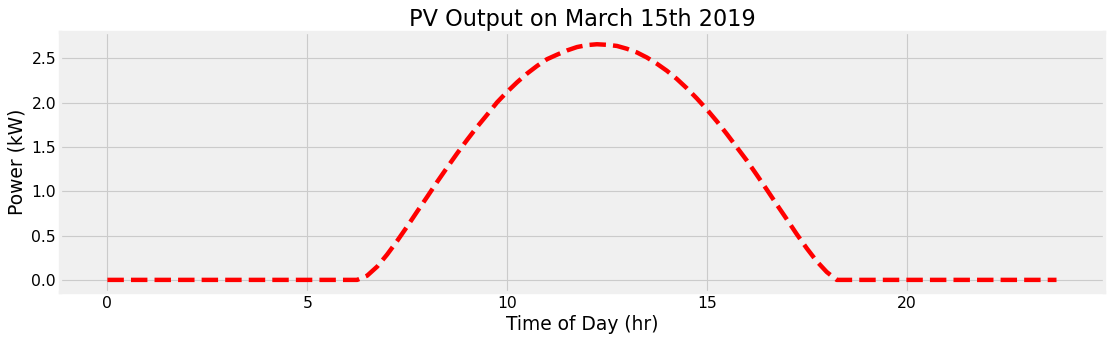

In [436]:
panel_output = (a_m2_panels * S_pv_15min) * eff_panels / 1000
plt.style.use('fivethirtyeight')
plt.figure(num=1, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
Hour = np.array(df_4['Hour_of_day'])
plt.plot(Hour, panel_output, 'r--')
plt.xlabel('Time of Day (hr)')
plt.ylabel('Power (kW)')
plt.title('PV Output on March 15th 2019')

### Co-Optimization

In [227]:
d_cost = {}
d_peak = {}

In [228]:
P_solar = list(panel_output)
P_home = (u*Q + z*P_heat)

In [283]:
P_g = P_home - P_solar
grid_cost_mult = 0.55
cost_g_arr = Variable(n)
constr_g = constr + [cost_g_arr >= grid_cost_mult * multiply(price, (P_g * dt))]
constr_g += [cost_g_arr >= multiply(price, (P_g * dt))]
cost_g = sum(cost_g_arr)
alpha = 1
T_min = 55
for i in range(n+1):
    cost_g += alpha*0.5*(maximum(0, -T[i]+T_min)**2)

In [284]:
# Solve optimization
# problem = Problem(Minimize(sum(cost_g)), constr)
problem = Problem(Minimize(cost_g), constr_g)
#problem.solve(solver="GUROBI",verbose=True,TimeLimit=20)
#HEURMAXSOL = 1, HEURMAXNODES =1000,
problem.solve(solver = MOSEK, 
              mosek_params = {mosek.dparam.optimizer_max_time:  120.0,
                              mosek.iparam.intpnt_solve_form:   mosek.solveform.dual}
             )
#problem.solve(solver="XPRESS",verbose=True,bariterlimit=2,barindeflimit=10,bargapstop=10, bardualstop=10, DEFAULTALG=2, barmemory=30)

12.756534408258982

In [285]:
# Cost of co-optimization
cost_final = sum(cost_g_arr).value
# The commented-out code below also works (but is less concise)
# for i in range(n):
#     if P_g.value[i] >= 0:
#         cost_final += price[i] * P_g.value[i] * dt
#     else:
#         cost_final += grid_cost_mult * price[i] * P_g.value[i] * dt
print("Cost of co-optimization: $", np.round(cost_final, 4))

Cost of co-optimization: $ 5.4546


In [286]:
# indices 68 -> 84 correspond to 4pm -> 9pm which are the on-peak hrs
perc_on_peak = 100 * sum(P_home[68:84]).value / sum(P_home).value
perc_on_peak

6.060621406500893

In [287]:
d_cost[grid_cost_mult] = cost_final
d_peak[grid_cost_mult] = perc_on_peak

In [288]:
d_peak

{0: 6.060606060606069,
 0.25: 6.060612980880667,
 0.5: 6.0606060606060606,
 0.75: 6.34923008898037,
 0.9: 6.349206349206349,
 0.98: 6.349207846473915,
 1: 6.349206440743919,
 0.7: 6.349215517397707,
 0.55: 6.060621406500893}

### Results

Optimal water heater temperature throughout the day, with shower and washing machine demands.

Text(0, 0.5, '% On-Peak Home Consumption')

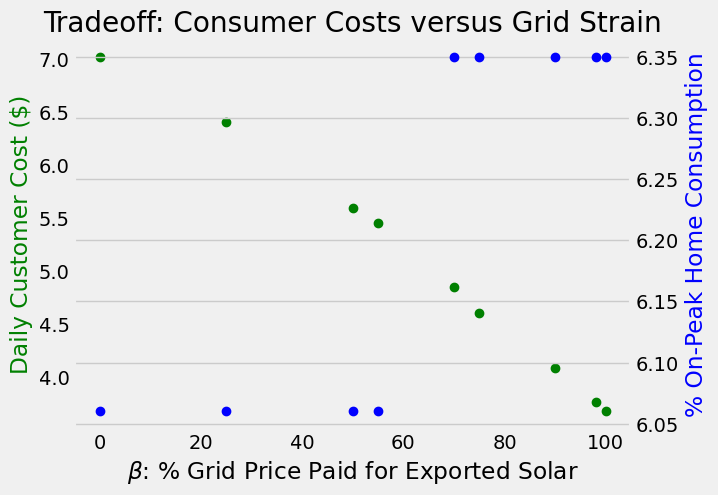

In [291]:
plt.style.use('fivethirtyeight')
x = list(d_cost.keys())
x = [i * 100 for i in x]
y1 = d_cost.values()
#plt.scatter(x,y)
y2 = d_peak.values()
#plt.scatter(x, d_peak.values())
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'go')
ax2.plot(x, y2, 'bo')
ax1.grid(False)

ax1.set_title('Tradeoff: Consumer Cost versus Grid Strain')
ax1.set_xlabel(r'$ \beta $' + ': % Grid Price Paid for Exported Solar')
ax1.set_ylabel('Daily Customer Cost ($)', color='g')
ax2.set_ylabel('% On-Peak Home Consumption', color='b')

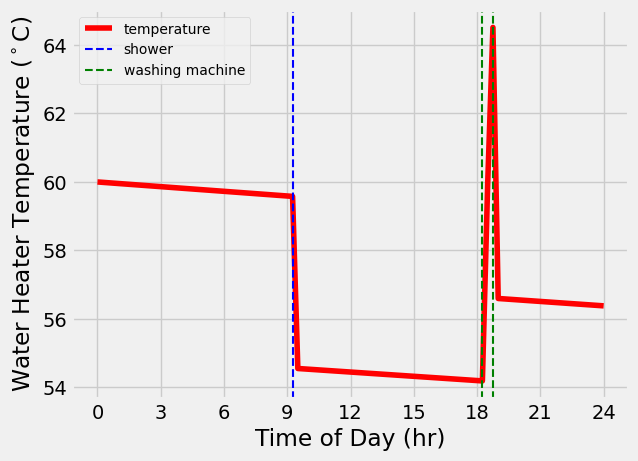

In [235]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
plt.plot(T.value, 'red')
plt.xlabel('Time of Day (hr)')
plt.ylabel('Water Heater Temperature ($^\circ$C)')
plt.xticks([0,12,24,36,48,60,72,84,96]);
ax.set_xticklabels([0,3,6,9,12,15,18,21,24]);
position = [37,73,75]
colors = ['blue', 'green','green','green']
labels = []
for i,xc in enumerate(position):
    plt.axvline(x=xc, color=colors[i], linestyle='--', linewidth = 1.5)
plt.legend(['temperature','shower', 'washing machine'], prop={'size': 10});

Optimal water heater state (on/off) throughout the day, with shower and washing machine demands.

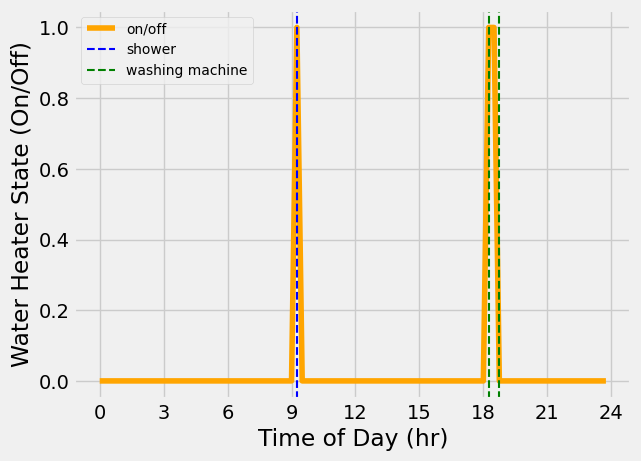

In [236]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
plt.plot(u.value, 'orange')
plt.xlabel('Time of Day (hr)')
plt.ylabel('Water Heater State (On/Off)')
plt.xticks([0,12,24,36,48,60,72,84,96]);
ax.set_xticklabels([0,3,6,9,12,15,18,21,24]);
position = [37,73,75]
colors = ['blue', 'green','green','green']
for i,xc in enumerate(position):
    plt.axvline(x=xc, color=colors[i], linestyle='--', linewidth = 1.5)
plt.legend(['on/off','shower', 'washing machine'], prop={'size': 10});

Optimal HVAC temperature throughout the day.

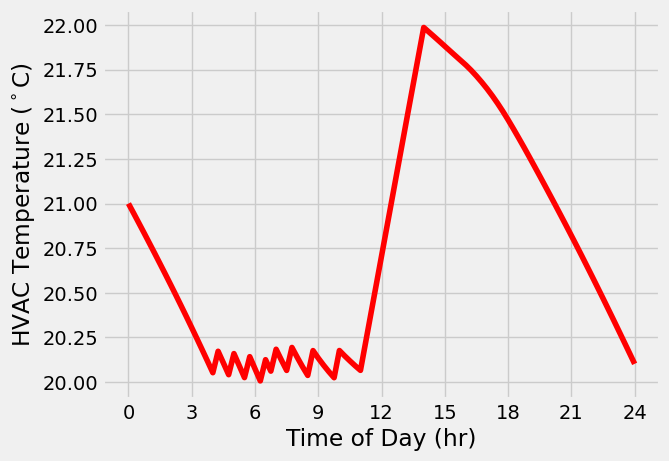

In [237]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
plt.plot(T_in.value, 'red')
plt.xlabel('Time of Day (hr)')
plt.ylabel('HVAC Temperature ($^\circ$C)')
plt.xticks([0,12,24,36,48,60,72,84,96]);
ax.set_xticklabels([0,3,6,9,12,15,18,21,24]);

Optimal HVAC state (on/off) throughout the day.

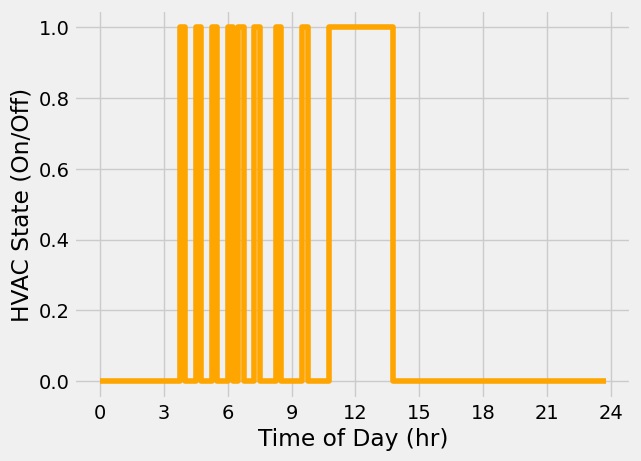

In [238]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
plt.step(z.value, 'orange')
plt.xlabel('Time of Day (hr)')
plt.ylabel('HVAC State (On/Off)')
plt.xticks([0,12,24,36,48,60,72,84,96]);
ax.set_xticklabels([0,3,6,9,12,15,18,21,24]);

Value of co-optimization

In [348]:
# Perform parallel optimization
# Solve optimization
problem = Problem(Minimize(cost), constr)
problem.solve(solver="XPRESS",verbose=True,bariterlimit=2,barindeflimit=1,bargapstop=1,bardualstop=1,barmemory=30)

                                     CVXPY                                     
                                    v1.1.11                                    
(CVXPY) May 06 09:41:10 AM: Your problem has 386 variables, 482 constraints, and 0 parameters.
(CVXPY) May 06 09:41:10 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 06 09:41:10 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 06 09:41:10 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 06 09:41:10 AM: Compiling problem (target solver=XPRESS).
(CVXPY) May 06 09:41:10 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStu

16.202427662237692

In [349]:
# Cost of co-optimization
print("Cost of co-optimization: $", np.round(sum(multiply(price*Q, u*dt)).value + sum(multiply(price*P_heat, z*dt)).value, 4))

Cost of co-optimization: $ 8.9005


In [364]:
def get_cost(P_parallel, price, dt, beta, n):
    cost = 0
    for i in range(n):
        if P_parallel[i] >= 0:
            cost += price[i] * P_parallel[i] * dt
        else:
            cost += beta * price[i] * P_parallel[i] * dt
    return cost

In [395]:
P_home_parallel = multiply(u,Q).value + multiply(z,P_heat).value
P_parallel =  P_home_parallel - P_solar
betas = list(d_cost.keys())
d_cost_parallel = {}
for b in betas:
    d_cost_parallel[b] = get_cost(P_parallel, price, dt, b, n)
d_cost_parallel

{0: 7.968041947140828,
 0.25: 6.803995150906804,
 0.5: 5.639948354672779,
 0.75: 4.475901558438754,
 0.9: 3.7774734806983377,
 0.98: 3.4049785059034505,
 1: 3.311854762204728,
 0.7: 4.7087109176855595,
 0.55: 5.407138995425973}

Text(0, 0.5, 'Daily Customer Cost ($)')

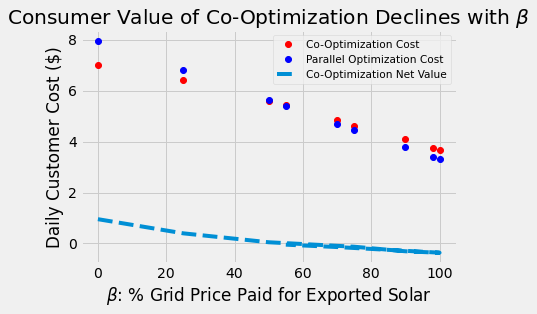

In [428]:
plt.style.use('fivethirtyeight')
x = betas
x = [i * 100 for i in x]
y1 = d_cost.values()
#plt.scatter(x,y)
y2 = d_cost_parallel.values()
#plt.scatter(x, d_peak.values())
fig, ax1 = plt.subplots()
d_diff = {}
for b in betas:
    d_diff[b] = d_cost_parallel[b] - d_cost[b]

y3 = d_diff.values()
    
ax1.plot(x, y1, 'or', label='Co-Optimization Cost')
ax1.plot(x, y2, 'bo', label='Parallel Optimization Cost')
ax1.plot(x, y3, '--', label='Co-Optimization Net Value')
ax1.legend(loc="upper right", prop={'size': 10.5})

ax1.set_title('Consumer Value of Co-Optimization Declines with ' + r'$ \beta $')
ax1.set_xlabel(r'$ \beta $' + ': % Grid Price Paid for Exported Solar')
ax1.set_ylabel('Daily Customer Cost ($)')

In [401]:
# indices 68 -> 84 correspond to 4pm -> 9pm which are the on-peak hrs
perc_on_peak_parallel = 100 * sum(P_home_parallel[68:84]).value / sum(P_home_parallel).value
perc_on_peak_parallel

21.666666666666664

In [402]:
d_peak

{0: 6.060606060606069,
 0.25: 6.060612980880667,
 0.5: 6.0606060606060606,
 0.75: 6.34923008898037,
 0.9: 6.349206349206349,
 0.98: 6.349207846473915,
 1: 6.349206440743919,
 0.7: 6.349215517397707,
 0.55: 6.060621406500893}

In [403]:
d_peak_parallel = {}
for k in d_peak.keys():
    # same for all beta values, because operation is independent of solar tariff
    d_peak_parallel[k] = perc_on_peak_parallel
d_peak_parallel

{0: 21.666666666666664,
 0.25: 21.666666666666664,
 0.5: 21.666666666666664,
 0.75: 21.666666666666664,
 0.9: 21.666666666666664,
 0.98: 21.666666666666664,
 1: 21.666666666666664,
 0.7: 21.666666666666664,
 0.55: 21.666666666666664}

Text(0, 0.5, '% On-Peak Home Consumption')

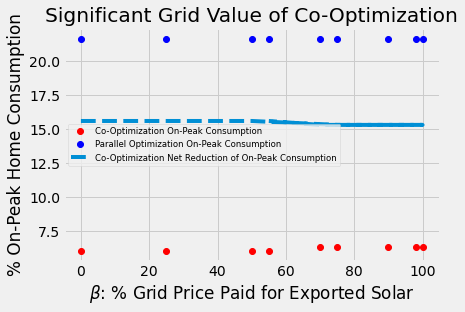

In [433]:
plt.style.use('fivethirtyeight')
x = betas
x = [i * 100 for i in x]
y1 = d_peak.values()
#plt.scatter(x,y)
y2 = d_peak_parallel.values()
#plt.scatter(x, d_peak.values())
fig, ax1 = plt.subplots()
d_diff = {}
for b in betas:
    d_diff[b] = d_peak_parallel[b] - d_peak[b]

y3 = d_diff.values()
    
ax1.plot(x, y1, 'or', label='Co-Optimization On-Peak Consumption')
ax1.plot(x, y2, 'bo', label='Parallel Optimization On-Peak Consumption')
ax1.plot(x, y3, '--', label='Co-Optimization Net Reduction of On-Peak Consumption')
ax1.legend(loc='best', prop={'size':8.5})

ax1.set_title('Significant Grid Value of Co-Optimization')
ax1.set_xlabel(r'$ \beta $' + ': % Grid Price Paid for Exported Solar')
ax1.set_ylabel('% On-Peak Home Consumption')